## TP3: Reconnaissance de signaux de communication par apprentissage profond

Students:
- Mathilde Dupouy
- Balthazar Neveu

In [ ]:
# %general imports
from data_loader import get_data, SignalsDataset, SAMPLE_DATA_PATH

from visualization import visualize_signals
from random import randint
interactive_flag = True
try:
    from ipywidgets import interact, IntSlider, fixed
    interactive_flag *= True
except:
    interactive_flag = False

%load_ext autoreload
%autoreload 2

# Data loader
@TODO: comment on data, label_dict

In [ ]:
# % data loading from disk
signals, snr, labels_id, label_dict = get_data()
data_in = [signals, snr, labels_id, label_dict]

In [ ]:
# % interactive visualization
data_in = [signals, snr, labels_id, label_dict]
if interactive_flag:
    interact(
        visualize_signals,
        data_in = fixed(data_in),
        idx=IntSlider(min=0, max=signals.shape[0]-1, step=1))
else:
    for idx in range(5):
        visualize_signals(data_in = data_in, idx=randint(0, signals.shape[0]-1))

In [ ]:
# % check toy dataloader
from data_loader import get_data, SignalsDataset, SAMPLE_DATA_PATH
from torch.utils.data import DataLoader
N = 8  # batch size
C = 2 # number of channels
T = 2048 # signal length


dataset = SignalsDataset(SAMPLE_DATA_PATH)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
batch_signal, batch_labels = next(iter(train_dataloader))
assert batch_signal.shape == (N, C, T) # A batch shall be a 8, 2, 2048 tensor

## Vanilla classifier

In [23]:
from model import VanillaClassifier
%load_ext autoreload
%autoreload 2

device = "cuda"
model = VanillaClassifier()
def sanity_check():
# model.to(device)
# Sanity check on inference
    pred = model(batch_signal)
    print(pred.shape, batch_labels.shape)
    import torch
    loss = torch.nn.CrossEntropyLoss()
    loss(pred, batch_labels[:, 0])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from training import train
from data_loader import get_dataloaders
dataloaders = get_dataloaders()



In [ ]:
import torch
torch.cuda.is_available()

In [26]:
model, training_losses, valid_losses = train(model, batch_sizes=(256, 512), n_epochs=30)

Epoch 0: 100%|██████████| 118/118 [00:02<00:00, 52.38it/s]


epoch=0 | training_loss=1.649 | valid_loss=1.64


Epoch 1: 100%|██████████| 118/118 [00:01<00:00, 60.26it/s]


epoch=1 | training_loss=1.620 | valid_loss=1.6


Epoch 2: 100%|██████████| 118/118 [00:01<00:00, 60.22it/s]


epoch=2 | training_loss=1.587 | valid_loss=1.57


Epoch 3: 100%|██████████| 118/118 [00:01<00:00, 59.34it/s]


epoch=3 | training_loss=1.551 | valid_loss=1.53


Epoch 4: 100%|██████████| 118/118 [00:01<00:00, 60.30it/s]


epoch=4 | training_loss=1.513 | valid_loss=1.5


Epoch 5: 100%|██████████| 118/118 [00:02<00:00, 58.68it/s]


epoch=5 | training_loss=1.476 | valid_loss=1.46


Epoch 6: 100%|██████████| 118/118 [00:02<00:00, 54.76it/s]


epoch=6 | training_loss=1.440 | valid_loss=1.42


Epoch 7: 100%|██████████| 118/118 [00:02<00:00, 55.42it/s]


epoch=7 | training_loss=1.406 | valid_loss=1.39


Epoch 8: 100%|██████████| 118/118 [00:02<00:00, 55.21it/s]


epoch=8 | training_loss=1.374 | valid_loss=1.36


Epoch 9: 100%|██████████| 118/118 [00:02<00:00, 57.22it/s]


epoch=9 | training_loss=1.346 | valid_loss=1.33


Epoch 10: 100%|██████████| 118/118 [00:02<00:00, 58.28it/s]


epoch=10 | training_loss=1.322 | valid_loss=1.31


Epoch 11: 100%|██████████| 118/118 [00:02<00:00, 56.54it/s]


epoch=11 | training_loss=1.301 | valid_loss=1.29


Epoch 12: 100%|██████████| 118/118 [00:02<00:00, 57.82it/s]


epoch=12 | training_loss=1.282 | valid_loss=1.27


Epoch 13: 100%|██████████| 118/118 [00:02<00:00, 57.47it/s]


epoch=13 | training_loss=1.267 | valid_loss=1.26


Epoch 14: 100%|██████████| 118/118 [00:02<00:00, 58.83it/s]


epoch=14 | training_loss=1.254 | valid_loss=1.25


Epoch 15: 100%|██████████| 118/118 [00:02<00:00, 57.58it/s]


epoch=15 | training_loss=1.243 | valid_loss=1.24


Epoch 16: 100%|██████████| 118/118 [00:02<00:00, 58.50it/s]


epoch=16 | training_loss=1.233 | valid_loss=1.23


Epoch 17: 100%|██████████| 118/118 [00:02<00:00, 57.36it/s]


epoch=17 | training_loss=1.225 | valid_loss=1.22


Epoch 18: 100%|██████████| 118/118 [00:02<00:00, 58.35it/s]


epoch=18 | training_loss=1.218 | valid_loss=1.21


Epoch 19: 100%|██████████| 118/118 [00:02<00:00, 58.94it/s]


epoch=19 | training_loss=1.212 | valid_loss=1.21


Epoch 20: 100%|██████████| 118/118 [00:02<00:00, 58.66it/s]


epoch=20 | training_loss=1.206 | valid_loss=1.2


Epoch 21: 100%|██████████| 118/118 [00:02<00:00, 57.71it/s]


epoch=21 | training_loss=1.201 | valid_loss=1.2


Epoch 22: 100%|██████████| 118/118 [00:02<00:00, 52.15it/s]


epoch=22 | training_loss=1.197 | valid_loss=1.2


Epoch 23: 100%|██████████| 118/118 [00:02<00:00, 58.74it/s]


epoch=23 | training_loss=1.193 | valid_loss=1.19


Epoch 24: 100%|██████████| 118/118 [00:02<00:00, 57.10it/s]


epoch=24 | training_loss=1.190 | valid_loss=1.19


Epoch 25: 100%|██████████| 118/118 [00:02<00:00, 58.50it/s]


epoch=25 | training_loss=1.187 | valid_loss=1.19


Epoch 26: 100%|██████████| 118/118 [00:02<00:00, 57.33it/s]


epoch=26 | training_loss=1.184 | valid_loss=1.18


Epoch 27: 100%|██████████| 118/118 [00:02<00:00, 57.53it/s]


epoch=27 | training_loss=1.181 | valid_loss=1.18


Epoch 28: 100%|██████████| 118/118 [00:02<00:00, 58.14it/s]


epoch=28 | training_loss=1.179 | valid_loss=1.18


Epoch 29: 100%|██████████| 118/118 [00:02<00:00, 58.26it/s]


epoch=29 | training_loss=1.177 | valid_loss=1.18


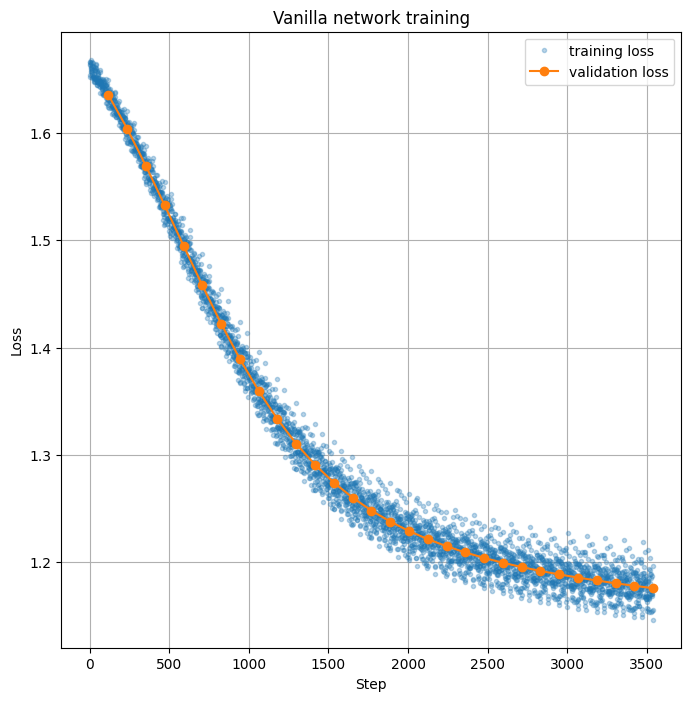

In [39]:
import matplotlib.pyplot as plt
import numpy as np
epoch_length = len(training_losses)/len(valid_losses)
epoch_steps = np.linspace(epoch_length, len(training_losses), len(valid_losses)) 

plt.figure(figsize=(8, 8))
plt.plot(training_losses, ".", alpha=0.3, label="training loss")

plt.plot(epoch_steps, valid_losses,  "-o", label="validation loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Vanilla network training")
plt.grid()
plt.show()